In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, 
    Bidirectional, LSTM, Dropout, 
    RepeatVector, TimeDistributed, Dense, Flatten, Lambda
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import kerastuner as kt

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


2025-05-13 05:48:35.532157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747115315.720899      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747115315.777149      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_35/1003894650.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
df = pd.read_csv('/kaggle/input/tesla-stock/fix_tesla_stock.csv')
df['date'] = pd.to_datetime(df['date'])
train_dates = pd.to_datetime(df['date'])
cols = ['Open','High', 'Low','Close','Volume','Adj Close','P_mean']

df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2022-01-03,382.583344,400.356659,378.679993,399.926666,103931400.0,399.926666,0.277932
2022-01-04,396.516663,402.666656,374.350006,383.196655,100248300.0,383.196655,0.140703
2022-01-05,382.216675,390.113342,360.336670,362.706665,80119800.0,362.706665,0.206361
2022-01-06,359.000000,362.666656,340.166656,354.899994,90336600.0,354.899994,0.182063
2022-01-07,360.123322,360.309998,336.666656,342.320007,84164700.0,342.320007,0.182063
...,...,...,...,...,...,...,...
2024-04-23,143.330002,147.259995,141.110001,144.679993,124545100.0,144.679993,0.199721
2024-04-24,162.839996,167.970001,157.509995,162.130005,181178000.0,162.130005,0.079026
2024-04-25,158.960007,170.880005,158.360001,170.179993,126427500.0,170.179993,0.199589


In [3]:
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaled_target = scaler_for_inference.fit_transform(df_for_training[['Open', 'Adj Close']])

## Data preparation

In [4]:
n_past = 29
n_future = 1  

X, Y = [], []

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    X.append(df_for_training_scaled[i - n_past:i, :]) # X berisi semua fitur
    Y.append(scaled_target[i:i+n_future, :]) # Y berisi 10 hari ke depan untuk fitur Open dan Adj Close

X = np.array(X)
Y = np.array(Y)

print(f"X shape = {X.shape}")  # (samples, 60, 7) setiap sample berisi 60 data historis dan 7 fitur
print(f"Y shape = {Y.shape}")  # (samples, 10, 2) setiap sample berisi 10 data yang ingin diprediksi (masa depan) dan 2 fitur yakni var target

X shape = (554, 29, 7)
Y shape = (554, 1, 2)


## Spliting

In [98]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (398, 29, 7)
X_val shape: (45, 29, 7)
X_test shape: (111, 29, 7)


## Modeling

In [6]:
n_features = X_train.shape[2] 
n_output = y_train.shape[2]
epochs = 50
batch_size = 32
model_id = 1
save_dir = f"experiments/exp_model_{model_id}"

In [7]:
dates_all_targets = pd.to_datetime(df['date'])[n_past + n_future - 1:]
dates_train_temp, dates_test = train_test_split(dates_all_targets, test_size=0.2, shuffle=False)
dates_train, dates_val = train_test_split(dates_train_temp, test_size=0.1, shuffle=False)

In [8]:
model_variations = pd.DataFrame([
    [64, 32, 0.2, 0.2, 128, 128, 'adam'],
    [64, 32, 0.2, 0.3, 128, 256, 'adam'],
    [64, 32, 0.3, 0.3, 256, 128, 'adam'],
    [64, 32, 0.3, 0.2, 256, 256, 'adam'],
    [128, 64, 0.2, 0.2, 128, 128, 'adam'],
    [128, 64, 0.2, 0.3, 128, 256, 'adam'],
    [128, 64, 0.3, 0.3, 256, 128, 'adam'],
    [128, 64, 0.3, 0.2, 256, 256, 'adam'],
    [128, 64, 0.2, 0.2, 512, 128, 'rmsprop'],
    [128, 64, 0.2, 0.3, 512, 256, 'rmsprop'],
    [256, 128, 0.2, 0.2, 128, 128, 'rmsprop'],
    [256, 128, 0.2, 0.3, 128, 256, 'rmsprop'],
    [256, 128, 0.3, 0.3, 256, 128, 'rmsprop'],
    [256, 128, 0.3, 0.2, 256, 256, 'rmsprop'],
    [256, 128, 0.2, 0.2, 512, 128, 'rmsprop'],
    [256, 128, 0.2, 0.3, 512, 256, 'rmsprop'],
    #tambahan
    [64, 32, 0.2, 0.2, 128, 128, 'rmsprop'],
    [64, 32, 0.2, 0.3, 128, 256, 'rmsprop'],
    [64, 32, 0.3, 0.3, 256, 128, 'rmsprop'],
    [64, 32, 0.3, 0.2, 256, 256, 'rmsprop'],
    [128, 64, 0.2, 0.2, 128, 128, 'rmsprop'],
    [128, 64, 0.2, 0.3, 128, 256, 'rmsprop'],
    [128, 64, 0.3, 0.3, 256, 128, 'rmsprop'],
    [128, 64, 0.3, 0.2, 256, 256, 'rmsprop'],
    [128, 64, 0.2, 0.2, 512, 128, 'adam'],
    [128, 64, 0.2, 0.3, 512, 256, 'adam'],
    [256, 128, 0.2, 0.2, 128, 128, 'adam'],
    [256, 128, 0.2, 0.3, 128, 256, 'adam'],
    [256, 128, 0.3, 0.3, 256, 128, 'adam'],
    [256, 128, 0.3, 0.2, 256, 256, 'adam'],
    [256, 128, 0.2, 0.2, 512, 128, 'adam'],
    [256, 128, 0.2, 0.3, 512, 256, 'adam'],
], columns=[
    'Conv1D F1', 'Conv1D F2', 'Dropout 1', 'Dropout 2',
    'LSTM Layer 1', 'LSTM Layer 2', 'Optimizer'
])
model_variations.index += 1
model_variations.index.name = 'Model ID'
model_variations['val_mse_open'] = None
model_variations['val_mse_adj_close'] = None

model_variations['train_mse_open'] = None
model_variations['train_mse_adj_close'] = None


In [9]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def plot_and_save_loss(history, save_dir, model_id):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Train vs Validation Loss during Training Model {model_id}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    loss_plot_path = os.path.join(save_dir, f"loss_plot_model_{model_id}.png")
    plt.savefig(loss_plot_path)
    plt.close()

def inverse_predictions(predictions, scaler):
    if predictions.ndim == 2:
        return scaler.inverse_transform(predictions).reshape(predictions.shape[0], 1, predictions.shape[1])
    elif predictions.ndim == 3:
        samples, n_future, n_features = predictions.shape
        predictions_flat = predictions.reshape(-1, n_features)
        inversed_flat = scaler.inverse_transform(predictions_flat)
        return inversed_flat.reshape(samples, n_future, n_features)
    else:
        raise ValueError("Unsupported prediction shape.")

def plot_predictions(y_true, y_pred, dates, feature_idx=0, set_name="Validation", feature_name="OPEN", save_path="prediction.png"):
    y_true_flat = y_true[:, 0, feature_idx]
    y_pred_flat = y_pred[:, 0, feature_idx]

    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true_flat, label='True', linestyle='-', marker='o', markersize=3)
    plt.plot(dates, y_pred_flat, label='Predicted', linestyle='--', marker='x', markersize=3)
    plt.title(f'{set_name} Set - {feature_name} (Inverse Transformed)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def save_model_weights(model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, layer in enumerate(model.layers):
        for j, w in enumerate(layer.get_weights()):
            np.save(os.path.join(save_dir, f"layer_{i}_{layer.name}_w{j}.npy"), w)
    with zipfile.ZipFile(save_dir + ".zip", 'w', zipfile.ZIP_DEFLATED) as z:
        for root, _, files in os.walk(save_dir):
            for file in files:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, start=save_dir)
                z.write(full_path, arcname)

def evaluate_and_save_experiment(model, 
                                 X_val, y_val, 
                                 X_train, y_train, 
                                 scaler, 
                                 save_dir, 
                                 dates_val, dates_train,
                                 feature_names=['Open', 'Adj Close']):

    os.makedirs(save_dir, exist_ok=True)

    y_val_pred = model.predict(X_val, verbose=0)
    y_val_true_inv = inverse_predictions(y_val, scaler)
    y_val_pred_inv = inverse_predictions(y_val_pred, scaler)

    y_train_pred = model.predict(X_train, verbose=0)
    y_train_true_inv = inverse_predictions(y_train, scaler)
    y_train_pred_inv = inverse_predictions(y_train_pred, scaler)

    save_model_weights(model, os.path.join(save_dir, "weights"))

    metrics = {'Validation': {}, 'Train': {}}

    for i, name in enumerate(feature_names):
        plot_predictions(y_val_true_inv, y_val_pred_inv, dates_val, 
                         feature_idx=i, set_name="Validation", 
                         feature_name=name, 
                         save_path=os.path.join(save_dir, f"val_predictions_{name}.png"))
        
        plot_predictions(y_train_true_inv, y_train_pred_inv, dates_train, 
                         feature_idx=i, set_name="Train", 
                         feature_name=name, 
                         save_path=os.path.join(save_dir, f"train_predictions_{name}.png"))

        val_true = y_val_true_inv[:, 0, i]
        val_pred = y_val_pred_inv[:, 0, i]
        metrics['Validation'][name] = {
            'MSE': mean_squared_error(val_true, val_pred),
            'MAE': mean_absolute_error(val_true, val_pred),
            'RMSE': mean_squared_error(val_true, val_pred, squared=False),
            'MAPE': mean_absolute_percentage_error(val_true, val_pred)
        }

        train_true = y_train_true_inv[:, 0, i]
        train_pred = y_train_pred_inv[:, 0, i]
        metrics['Train'][name] = {
            'MSE': mean_squared_error(train_true, train_pred),
            'MAE': mean_absolute_error(train_true, train_pred),
            'RMSE': mean_squared_error(train_true, train_pred, squared=False),
            'MAPE': mean_absolute_percentage_error(train_true, train_pred)
        }

    metrics_path = os.path.join(save_dir, "metrics.txt")
    with open(metrics_path, "w") as f:
        for phase in metrics:
            f.write(f"== {phase} Metrics ==\n")
            for name, m in metrics[phase].items():
                f.write(f"Feature: {name}\n")
                for k, v in m.items():
                    f.write(f"{k}: {v:.6f}\n")
                f.write("\n")
            f.write("\n")

    return metrics

def update_model_results(model_id, metrics):
    global model_variations
    model_variations.loc[model_id, 'val_mse_open'] = metrics['Validation']['Open']['MSE']
    model_variations.loc[model_id, 'val_mse_adj_close'] = metrics['Validation']['Adj Close']['MSE']
    model_variations.loc[model_id, 'train_mse_open'] = metrics['Train']['Open']['MSE']
    model_variations.loc[model_id, 'train_mse_adj_close'] = metrics['Train']['Adj Close']['MSE']
    print(f"Metrics untuk Model {model_id} berhasil disimpan (val + train).")

### Model 1

In [10]:
def build_model_1(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    # CNN Layers
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    # BiLSTM Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    # Fully Connected Layers
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    # Compile
    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model

In [11]:
model_id = 1
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_1(input_shape=(n_past, n_features), n_output=n_output)


history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747115328.758138      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747115328.758785      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 13, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 13, 32)              │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 13, 2)               │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572,482 (2.18 MB)

 Trainable params: 572,482 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1747115337.541981      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - loss: 0.0899 - val_loss: 0.0072
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0147 - val_loss: 0.0071
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0106 - val_loss: 0.0046
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val

### Model 2

In [12]:
def build_model_2(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    # CNN Layers
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    # BiLSTM Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    # Compile
    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model

In [13]:
model_id = 2
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_2(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 13, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 13, 32)              │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 13, 2)               │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,237,058 (4.72 MB)

 Trainable params: 1,237,058 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.1067 - val_loss: 0.0088
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125 - val_loss: 0.0033
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 3

In [96]:
def build_model_3(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model

In [97]:
model_id = 3
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_3(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)                   │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_66 (Bidirectional)     │ (None, 13, 512)             │         591,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_67 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_66                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_67                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_33 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,261,634 (4.81 MB)

 Trainable params: 1,261,634 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0743 - val_loss: 0.0035
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0107 - val_loss: 0.0032
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 4

In [16]:
def build_model_4(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model


In [17]:
model_id = 4
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_4(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 13, 512)             │         591,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 13, 32)              │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 13, 2)               │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_3 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,188,354 (8.35 MB)

 Trainable params: 2,188,354 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0852 - val_loss: 0.0071
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0114 - val_loss: 0.0028
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 5

In [18]:
def build_model_5(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model

In [19]:
model_id = 5
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_5(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 13, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 13, 32)              │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 13, 2)               │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,530 (2.36 MB)

 Trainable params: 618,530 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0751 - val_loss: 0.0107
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0124 - val_loss: 0.0034
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 6

In [20]:
def build_model_6(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model


In [21]:
model_id = 6
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_6(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 13, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,106 (4.89 MB)

 Trainable params: 1,283,106 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0822 - val_loss: 0.0038
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0142 - val_loss: 0.0039
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 7

In [22]:
def build_model_7(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model


In [23]:
model_id = 7
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_7(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 13, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_6 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,450 (5.11 MB)

 Trainable params: 1,340,450 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0806 - val_loss: 0.0044
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0148 - val_loss: 0.0037
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0094 - val_loss: 0.0032
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 8

In [24]:
def build_model_8(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    return model


In [25]:
model_id = 8
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_8(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 13, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_7 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,267,170 (8.65 MB)

 Trainable params: 2,267,170 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.0735 - val_loss: 0.0069
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0124 - val_loss: 0.0081
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - val_loss: 0.0029
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

### Model 9

In [26]:
def build_model_9(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [27]:
model_id = 9
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_9(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 13, 1024)            │       2,363,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 13, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_8 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,570,722 (13.62 MB)

 Trainable params: 3,570,722 (13.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.1126 - val_loss: 0.0080
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0222 - val_loss: 0.0090
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0158 - val_loss: 0.0067
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0145 - val_loss: 0.0049
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0131 - val_loss: 0.0075
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - val_loss: 0.0041
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - val_loss: 0.0102
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0106 - val_loss: 0.0040
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 10

In [28]:
def build_model_10(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [29]:
model_id = 10
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_10(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 13, 1024)            │       2,363,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 13, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,021,730 (19.16 MB)

 Trainable params: 5,021,730 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.2469 - val_loss: 0.0270
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0272 - val_loss: 0.0167
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0294 - val_loss: 0.0093
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0173 - val_loss: 0.0201
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0242 - val_loss: 0.0093
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0155 - val_loss: 0.0115
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0161 - val_loss: 0.0086
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0122 - val_loss: 0.0077
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0123 - val_loss: 0.0051
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - val_loss: 0.0069
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.

### Model 11

In [30]:
def build_model_11(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [31]:
model_id = 11
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_11(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 13, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_10 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,202 (2.80 MB)

 Trainable params: 735,202 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.1203 - val_loss: 0.0147
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0216 - val_loss: 0.0058
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0260 - val_loss: 0.0099
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0219 - val_loss: 0.0111
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0170 - val_loss: 0.0092
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - val_loss: 0.0103
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0108 - val_loss: 0.0070
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - val_loss: 0.0067
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 12

In [32]:
def build_model_12(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [33]:
model_id = 12
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_12(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 13, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_11 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,399,778 (5.34 MB)

 Trainable params: 1,399,778 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.1285 - val_loss: 0.0044
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0196 - val_loss: 0.0152
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - val_loss: 0.0186
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0222 - val_loss: 0.0120
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - val_loss: 0.0213
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0204 - val_loss: 0.0130
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0146 - val_loss: 0.0112
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

### Model 13

In [34]:
def build_model_13(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [35]:
model_id = 13
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_13(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_24 (Bidirectional)     │ (None, 13, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_25 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_12 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,522,658 (5.81 MB)

 Trainable params: 1,522,658 (5.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.1597 - val_loss: 0.0080
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0179 - val_loss: 0.0268
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0271 - val_loss: 0.0160
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0180 - val_loss: 0.0104
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0204 - val_loss: 0.0106
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0169 - val_loss: 0.0087
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0029
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0108 - val_loss: 0.0086
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - val_loss: 0.0060
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 14

In [36]:
def build_model_14(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [37]:
model_id = 14
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_14(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_26 (Bidirectional)     │ (None, 13, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_27 (Bidirectional)     │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_13 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,449,378 (9.34 MB)

 Trainable params: 2,449,378 (9.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.3248 - val_loss: 0.0104
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0210 - val_loss: 0.0101
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0240 - val_loss: 0.0122
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0226 - val_loss: 0.0052
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0156 - val_loss: 0.0173
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0215 - val_loss: 0.0152
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0172 - val_loss: 0.0133
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0121 - val_loss: 0.0096
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0118 - val_loss: 0.0070
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0127 - val_loss: 0.0074
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 15

In [38]:
def build_model_15(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [39]:
model_id = 15
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_15(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_28 (Bidirectional)     │ (None, 13, 1024)            │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_29 (Bidirectional)     │ (None, 13, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_14 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,884,002 (14.82 MB)

 Trainable params: 3,884,002 (14.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.1397 - val_loss: 0.0107
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0214 - val_loss: 0.0255
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0267 - val_loss: 0.0233
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0243 - val_loss: 0.0123
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0193 - val_loss: 0.0120
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0143 - val_loss: 0.0091
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131 - val_loss: 0.0092
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0109 - val_loss: 0.0059
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

### Model 16

In [40]:
def build_model_16(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))  # Output layer

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model

In [41]:
model_id = 16
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_16(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)


metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_30 (Bidirectional)     │ (None, 13, 1024)            │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_31 (Bidirectional)     │ (None, 13, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_15 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,335,010 (20.35 MB)

 Trainable params: 5,335,010 (20.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.2117 - val_loss: 0.0325
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0234 - val_loss: 0.0324
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0221 - val_loss: 0.0038
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0164 - val_loss: 0.0036
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0183 - val_loss: 0.0039
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0152 - val_loss: 0.0135
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0360 - val_loss: 0.0055
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0184 - val_loss: 0.0094
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0129 - val_loss: 0.0099
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

### Model 17

In [42]:
def build_model_17(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [43]:
model_id = 17
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_17(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)                   │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_32 (Bidirectional)     │ (None, 13, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_33 (Bidirectional)     │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_16 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572,482 (2.18 MB)

 Trainable params: 572,482 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.1219 - val_loss: 0.0064
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0149 - val_loss: 0.0165
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0185 - val_loss: 0.0089
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0144 - val_loss: 0.0067
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0178 - val_loss: 0.0081
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - val_loss: 0.0044
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - val_loss: 0.0060
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - val_loss: 0.0055
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085 - val_loss: 0.0046
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.

### Model 18

In [44]:
def build_model_18(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))

    model.add(Lambda(lambda x: x[:, -1:, :]))    
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()

    return model


In [45]:
model_id = 18
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_18(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)                   │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 13, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_35 (Bidirectional)     │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_17 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,237,058 (4.72 MB)

 Trainable params: 1,237,058 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1396 - val_loss: 0.0045
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0148 - val_loss: 0.0071
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0147 - val_loss: 0.0061
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0218 - val_loss: 0.0048
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0131 - val_loss: 0.0063
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0135 - val_loss: 0.0109
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0139 - val_loss: 0.0093
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0142 - val_loss: 0.0035
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

### Model 19

In [46]:
def build_model_19(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Conv1D(64, 2, 1, 'valid', input_shape=input_shape))
    model.add(MaxPooling1D(2, 2))
    model.add(Conv1D(32, 2, 1, 'valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [47]:
model_id = 19
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_19(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_36 (Bidirectional)     │ (None, 13, 512)             │         591,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_37 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_18 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,261,634 (4.81 MB)

 Trainable params: 1,261,634 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.1036 - val_loss: 0.0236
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0202 - val_loss: 0.0162
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208 - val_loss: 0.0052
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0144 - val_loss: 0.0079
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0139 - val_loss: 0.0078
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0036
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0131 - val_loss: 0.0107
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0162 - val_loss: 0.0059
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

### Model 20

In [48]:
def build_model_20(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Conv1D(64, 2, 1, 'valid', input_shape=input_shape))
    model.add(MaxPooling1D(2, 2))
    model.add(Conv1D(32, 2, 1, 'valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [49]:
model_id = 20
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_20(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)                   │ (None, 28, 64)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ (None, 13, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_38 (Bidirectional)     │ (None, 13, 512)             │         591,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_39 (Bidirectional)     │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_19 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,188,354 (8.35 MB)

 Trainable params: 2,188,354 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.1742 - val_loss: 0.0101
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0260 - val_loss: 0.0084
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0157 - val_loss: 0.0056
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0157 - val_loss: 0.0071
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128 - val_loss: 0.0071
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0087
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - val_loss: 0.0117
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - val_loss: 0.0064
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - val_loss: 0.0048
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

### Model 21

In [50]:
def build_model_21(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Conv1D(128, 2, 1, 'valid', input_shape=input_shape))
    model.add(MaxPooling1D(2, 2))
    model.add(Conv1D(64, 2, 1, 'valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [51]:
model_id = 21
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_21(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_40 (Bidirectional)     │ (None, 13, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_41 (Bidirectional)     │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_20 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,530 (2.36 MB)

 Trainable params: 618,530 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.1381 - val_loss: 0.0108
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0189 - val_loss: 0.0077
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0173 - val_loss: 0.0074
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0250 - val_loss: 0.0069
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0120 - val_loss: 0.0074
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0117 - val_loss: 0.0086
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0121 - val_loss: 0.0081
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0048
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124 - val_loss: 0.0046
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 22

In [52]:
def build_model_22(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Conv1D(128, 2, 1, 'valid', input_shape=input_shape))
    model.add(MaxPooling1D(2, 2))
    model.add(Conv1D(64, 2, 1, 'valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))
    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [53]:
model_id = 22
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_22(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_42 (Bidirectional)     │ (None, 13, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_43 (Bidirectional)     │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_21 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,106 (4.89 MB)

 Trainable params: 1,283,106 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.1541 - val_loss: 0.0067
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0170 - val_loss: 0.0045
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0169 - val_loss: 0.0103
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0190 - val_loss: 0.0167
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0217 - val_loss: 0.0089
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0150 - val_loss: 0.0072
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0133 - val_loss: 0.0073
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128 - val_loss: 0.0071
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111 - val_loss: 0.0077
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

### Model 23

In [54]:
def build_model_23(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [55]:
model_id = 23
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_23(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_44 (Bidirectional)     │ (None, 13, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_45 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_45                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_22 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,450 (5.11 MB)

 Trainable params: 1,340,450 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.0918 - val_loss: 0.0290
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0313 - val_loss: 0.0099
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0170 - val_loss: 0.0222
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0229 - val_loss: 0.0122
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - val_loss: 0.0095
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0138 - val_loss: 0.0112
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0151 - val_loss: 0.0061
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 24

In [56]:
def build_model_24(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='rmsprop', loss='mse')
    model.summary()
    return model


In [57]:
model_id = 24
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_24(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_46 (Bidirectional)     │ (None, 13, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_47 (Bidirectional)     │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_46                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_47                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_23 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,267,170 (8.65 MB)

 Trainable params: 2,267,170 (8.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1320 - val_loss: 0.0103
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0219 - val_loss: 0.0068
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0242 - val_loss: 0.0135
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0197 - val_loss: 0.0107
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0169 - val_loss: 0.0075
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0159 - val_loss: 0.0085
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0139 - val_loss: 0.0064
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0116 - val_loss: 0.0065
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0099 - val_loss: 0.0066
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

### Model 25

In [58]:
def build_model_25(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [59]:
model_id = 25
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_25(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_48 (Bidirectional)     │ (None, 13, 1024)            │       2,363,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_49 (Bidirectional)     │ (None, 13, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_48                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_49                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_24 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,570,722 (13.62 MB)

 Trainable params: 3,570,722 (13.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.1055 - val_loss: 0.0063
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0161 - val_loss: 0.0053
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0101 - val_loss: 0.0037
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

### Model 26

In [60]:
def build_model_26(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [61]:
model_id = 26
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_26(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_50 (Conv1D)                   │ (None, 28, 128)             │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 13, 64)              │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_50 (Bidirectional)     │ (None, 13, 1024)            │       2,363,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_51 (Bidirectional)     │ (None, 13, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_50                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_51                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_25 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,021,730 (19.16 MB)

 Trainable params: 5,021,730 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - loss: 0.0725 - val_loss: 0.0223
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0151 - val_loss: 0.0056
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0089 - val_loss: 0.0032
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.

### Model 27

In [62]:
def build_model_27(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [63]:
model_id = 27
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_27(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_52 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_52 (Bidirectional)     │ (None, 13, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_53 (Bidirectional)     │ (None, 13, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_52                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_53                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_26 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,202 (2.80 MB)

 Trainable params: 735,202 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0851 - val_loss: 0.0044
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0143 - val_loss: 0.0036
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 28

In [64]:
def build_model_28(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [65]:
model_id = 28
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_28(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_54 (Bidirectional)     │ (None, 13, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_55 (Bidirectional)     │ (None, 13, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_54                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_55                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_27 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,399,778 (5.34 MB)

 Trainable params: 1,399,778 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.1003 - val_loss: 0.0035
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0129 - val_loss: 0.0036
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 29

In [66]:
def build_model_29(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [67]:
model_id = 29
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_29(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_56 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_57 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_56 (Bidirectional)     │ (None, 13, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_57 (Bidirectional)     │ (None, 13, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_28 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,522,658 (5.81 MB)

 Trainable params: 1,522,658 (5.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0860 - val_loss: 0.0057
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0161 - val_loss: 0.0037
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 30

In [68]:
def build_model_30(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [69]:
model_id = 30
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_30(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_58 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_58 (Bidirectional)     │ (None, 13, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_59 (Bidirectional)     │ (None, 13, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_58                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_59                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_29 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,449,378 (9.34 MB)

 Trainable params: 2,449,378 (9.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.1080 - val_loss: 0.0079
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0166 - val_loss: 0.0044
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

### Model 31

In [70]:
def build_model_31(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [71]:
model_id = 31
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_31(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_60 (Bidirectional)     │ (None, 13, 1024)            │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_61 (Bidirectional)     │ (None, 13, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_60                  │ (None, 13, 32)              │           8,224 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_61                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_30 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,884,002 (14.82 MB)

 Trainable params: 3,884,002 (14.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0743 - val_loss: 0.0079
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

### Model 32

In [72]:
def build_model_32(input_shape, n_output):
    tf.random.set_seed(seed)
    model = Sequential()

    model.add(Conv1D(filters=256, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid'))

    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_output, activation='linear')))
    model.add(Lambda(lambda x: x[:, -1:, :]))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model


In [73]:
model_id = 32
save_dir = f"experiments/exp_model_{model_id}"

model = build_model_32(input_shape=(n_past, n_features), n_output=n_output)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size, verbose=1)

metrics = evaluate_and_save_experiment(
    model=model,
    X_val=X_val,
    y_val=y_val,
    X_train=X_train,
    y_train=y_train,
    scaler=scaler_for_inference,
    save_dir=save_dir,
    dates_val=dates_val,
    dates_train=dates_train,
    feature_names=["Open", "Adj Close"]
)

plot_and_save_loss(history, save_dir, model_id)

update_model_results(model_id, metrics)

model_save_path = os.path.join(save_dir, "model.keras")
model.save(model_save_path)
print(f"Model berhasil disimpan ke {model_save_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_62 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_62 (Bidirectional)     │ (None, 13, 1024)            │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_63 (Bidirectional)     │ (None, 13, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_62                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_63                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_31 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,335,010 (20.35 MB)

 Trainable params: 5,335,010 (20.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0663 - val_loss: 0.0056
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0110 - val_loss: 0.0037
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0

## Final Model

In [126]:
model_variations['avg_mse'] = (model_variations['val_mse_open']+model_variations['val_mse_adj_close'])/2
model_variations

,Conv1D F1,Conv1D F2,Dropout 1,Dropout 2,LSTM Layer 1,LSTM Layer 2,Optimizer,val_mse_open,val_mse_adj_close,train_mse_open,train_mse_adj_close,avg_mse
Model ID,,,,,,,,,,,,
1,64,32,0.2,0.2,128,128,adam,67.683941,92.167722,95.245297,133.424394,79.925832
2,64,32,0.2,0.3,128,256,adam,53.841103,96.814927,49.878578,99.422345,75.328015
3,64,32,0.3,0.3,256,128,adam,50.126823,89.022794,49.847763,97.506909,69.574809
4,64,32,0.3,0.2,256,256,adam,41.180259,80.401476,40.45933,87.480371,60.790868
5,128,64,0.2,0.2,128,128,adam,49.239493,89.096713,58.707873,104.465334,69.168103
6,128,64,0.2,0.3,128,256,adam,44.116081,80.639087,42.870989,88.188953,62.377584
7,128,64,0.3,0.3,256,128,adam,82.708657,104.99097,98.576473,126.150405,93.849813
8,128,64,0.3,0.2,256,256,adam,43.316049,80.591713,36.030617,81.72344,61.953881
9,128,64,0.2,0.2,512,128,rmsprop,100.319553,176.837876,95.035088,156.032965,138.578714


In [127]:
model_variations.to_csv('Hyperparameter.csv')

In [128]:
best_model_id = model_variations['avg_mse'].idxmin()
func_name = f"build_model_{best_model_id}"
build_final_model = globals()[func_name]

In [129]:
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

In [130]:
save_dir_final = f"experiments/final_model_retrained"

final_model = build_final_model(input_shape=(n_past, n_features), n_output=n_output)

history_final = final_model.fit(X_train_full, y_train_full,
                                epochs=epochs, batch_size=batch_size, verbose=1)

metrics_final = evaluate_and_save_experiment(
    model=final_model,
    X_val=X_test,
    y_val=y_test,
    X_train=X_train_full,
    y_train=y_train_full,
    scaler=scaler_for_inference,
    save_dir=save_dir_final,
    dates_val=dates_test,
    dates_train=np.concatenate([dates_train, dates_val]),
    feature_names=["Open", "Adj Close"]
)

model_save_path = os.path.join(save_dir_final, "model.keras")
final_model.save(model_save_path)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)                   │ (None, 28, 256)             │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 13, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_72 (Bidirectional)     │ (None, 13, 1024)            │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_73 (Bidirectional)     │ (None, 13, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_72                  │ (None, 13, 32)              │          16,416 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_73                  │ (None, 13, 2)               │              66 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_36 (Lambda)                   │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,335,010 (20.35 MB)

 Trainable params: 5,335,010 (20.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0631
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0111
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0074
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoc

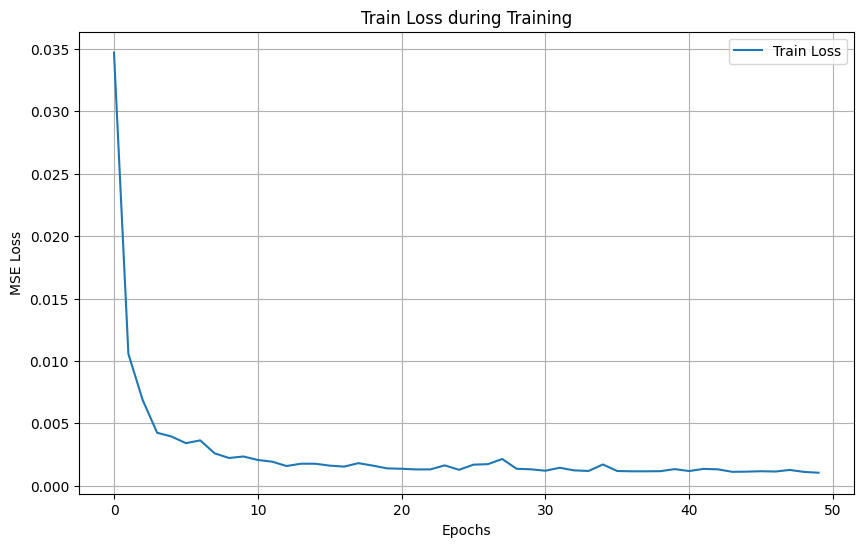

In [131]:
plt.figure(figsize=(10,6))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.title('Train Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi Final Model

In [132]:
y_train_pred = final_model.predict(X_train_full)
y_test_pred = final_model.predict(X_test)

y_train_pred_inv = scaler_for_inference.inverse_transform(y_train_pred.reshape(-1, 2)).reshape(-1, n_future, 2)
y_test_pred_inv = scaler_for_inference.inverse_transform(y_test_pred.reshape(-1, 2)).reshape(-1, n_future, 2)

y_train_true_inv = scaler_for_inference.inverse_transform(    y_train_full.reshape(-1, 2)).reshape(-1, n_future, 2)
y_test_true_inv = scaler_for_inference.inverse_transform(y_test.reshape(-1, 2)).reshape(-1, n_future, 2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [133]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred, feature_idx=0, one_step_only=True):
    if one_step_only:
        y_true_eval = y_true[:, 0, feature_idx]
        y_pred_eval = y_pred[:, 0, feature_idx]
    else:
        y_true_eval = y_true[:, :, feature_idx].flatten()
        y_pred_eval = y_pred[:, :, feature_idx].flatten()

    mse = mean_squared_error(y_true_eval, y_pred_eval)
    mae = mean_absolute_error(y_true_eval, y_pred_eval)
    rmse = np.sqrt(mse)
    epsilon = 1e-8
    mape = np.mean(np.abs((y_true_eval - y_pred_eval) / (y_true_eval + epsilon))) * 100

    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

In [134]:
train_open_metrics = evaluate_model(y_train_true_inv, y_train_pred_inv, feature_idx=0, one_step_only=True)
train_adj_metrics = evaluate_model(y_train_true_inv, y_train_pred_inv, feature_idx=1, one_step_only=True)

test_open_metrics = evaluate_model(y_test_true_inv, y_test_pred_inv, feature_idx=0, one_step_only=True)
test_adj_metrics = evaluate_model(y_test_true_inv, y_test_pred_inv, feature_idx=1, one_step_only=True)

print(f"\nEvaluation Train Set (Train+Val)")
print(f"OPEN     : MSE={train_open_metrics['MSE']:.2f}, MAE={train_open_metrics['MAE']:.2f}, RMSE={train_open_metrics['RMSE']:.2f}, MAPE={train_open_metrics['MAPE']:.2f}%")
print(f"ADJ CLOSE: MSE={train_adj_metrics['MSE']:.2f}, MAE={train_adj_metrics['MAE']:.2f}, RMSE={train_adj_metrics['RMSE']:.2f}, MAPE={train_adj_metrics['MAPE']:.2f}%")

print(f"\nEvaluation Test Set")
print(f"OPEN     : MSE={test_open_metrics['MSE']:.2f}, MAE={test_open_metrics['MAE']:.2f}, RMSE={test_open_metrics['RMSE']:.2f}, MAPE={test_open_metrics['MAPE']:.2f}%")
print(f"ADJ CLOSE: MSE={test_adj_metrics['MSE']:.2f}, MAE={test_adj_metrics['MAE']:.2f}, RMSE={test_adj_metrics['RMSE']:.2f}, MAPE={test_adj_metrics['MAPE']:.2f}%")



Evaluation Train Set (Train+Val)
OPEN     : MSE=35.27, MAE=4.57, RMSE=5.94, MAPE=2.02%
ADJ CLOSE: MSE=74.13, MAE=6.70, RMSE=8.61, MAPE=2.90%

Evaluation Test Set
OPEN     : MSE=32.40, MAE=4.35, RMSE=5.69, MAPE=2.22%
ADJ CLOSE: MSE=52.50, MAE=5.50, RMSE=7.25, MAPE=2.80%


In [135]:
def plot_prediction(y_true, y_pred, dates, feature_idx=0, set_name="Train", feature_name="OPEN"):
    y_true_one_step = y_true[:, 0, feature_idx]
    y_pred_one_step = y_pred[:, 0, feature_idx]

    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true_one_step, label='True', linestyle='-', marker='o', markersize=3)
    plt.plot(dates, y_pred_one_step, label='Predicted', linestyle='--', marker='x', markersize=3)
    plt.title(f'{set_name} Set - {feature_name} Tanpa Sentiment X')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

train_dates = pd.to_datetime(df['date'])
dates_adjusted = train_dates[n_past:]
dates_train_full, dates_test = train_test_split(dates_adjusted, test_size=0.2, shuffle=False)

print(f"dates_train_full shape: {dates_train_full.shape}")
print(f"dates_test shape: {dates_test.shape}")


dates_train_full shape: (443,)
dates_test shape: (111,)


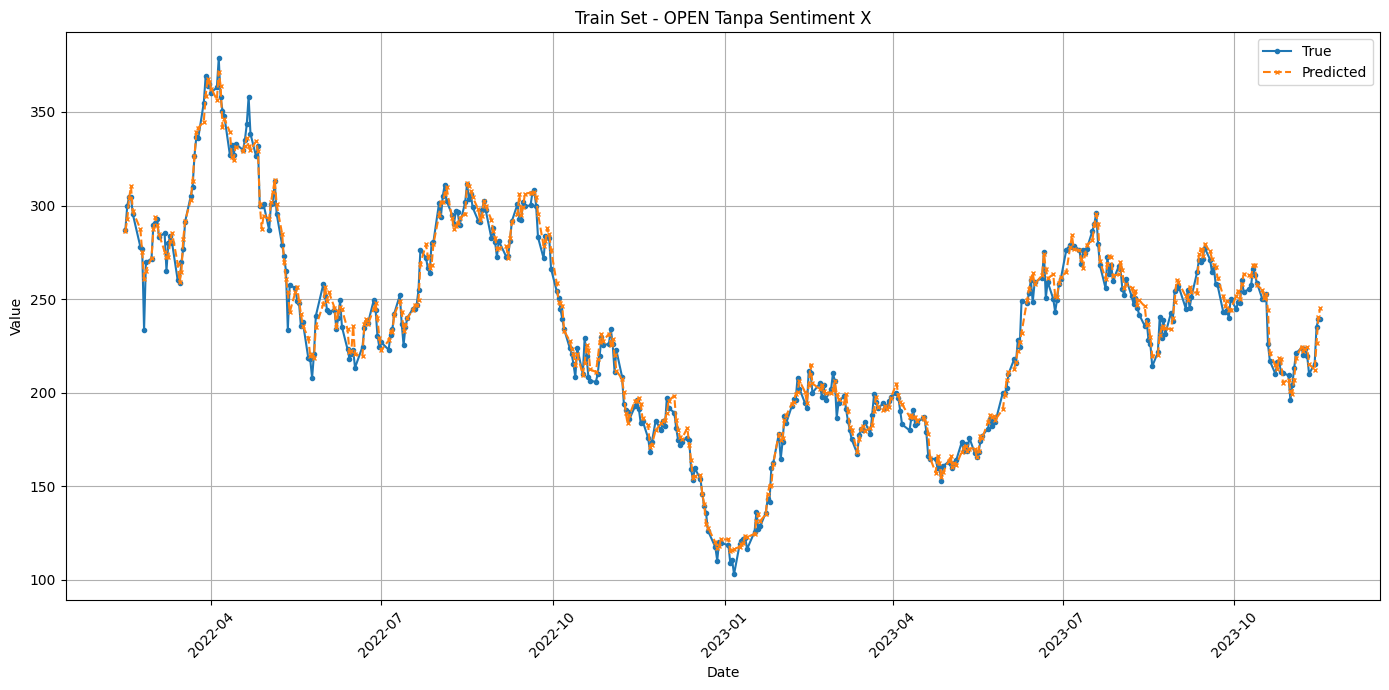

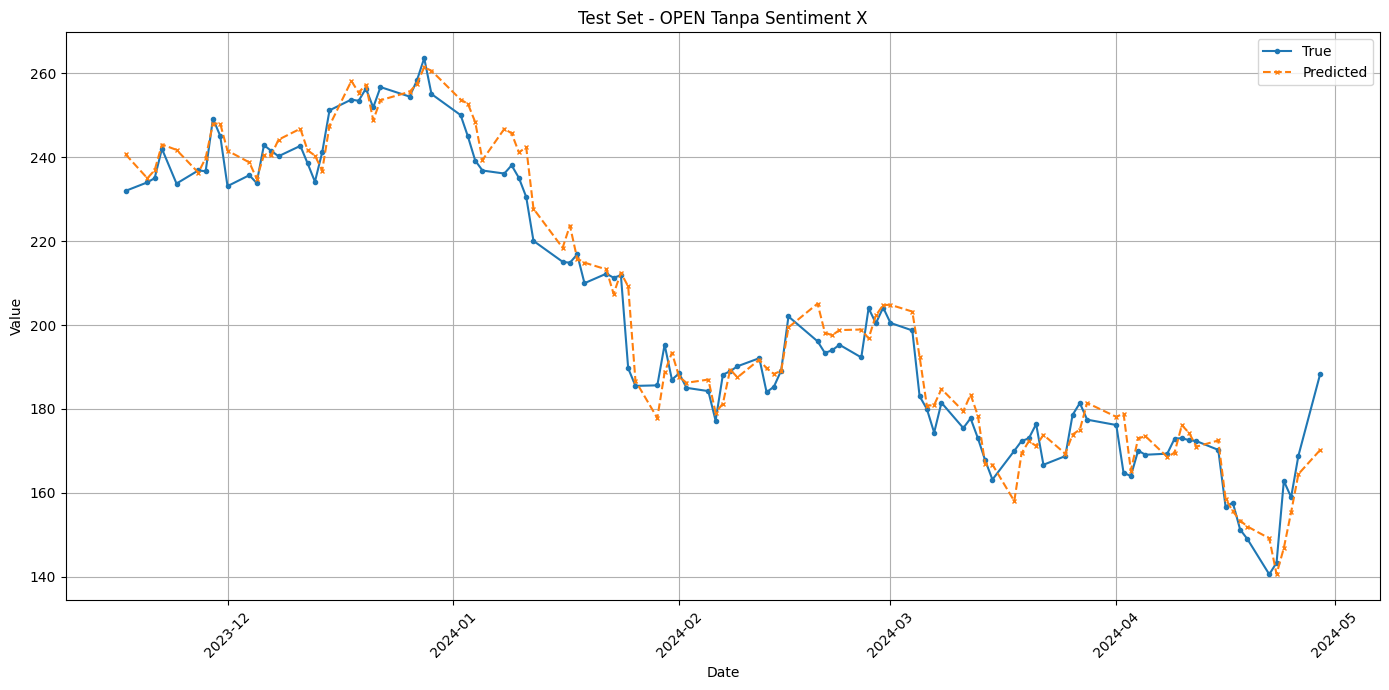

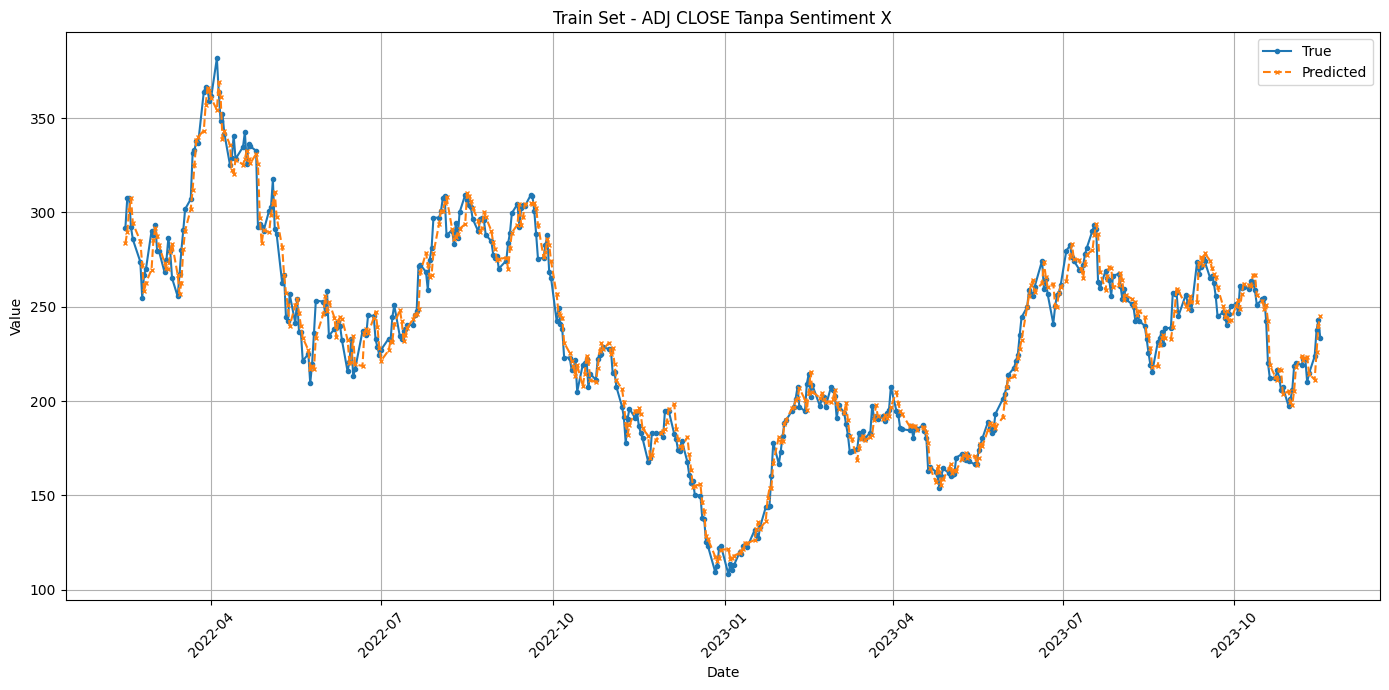

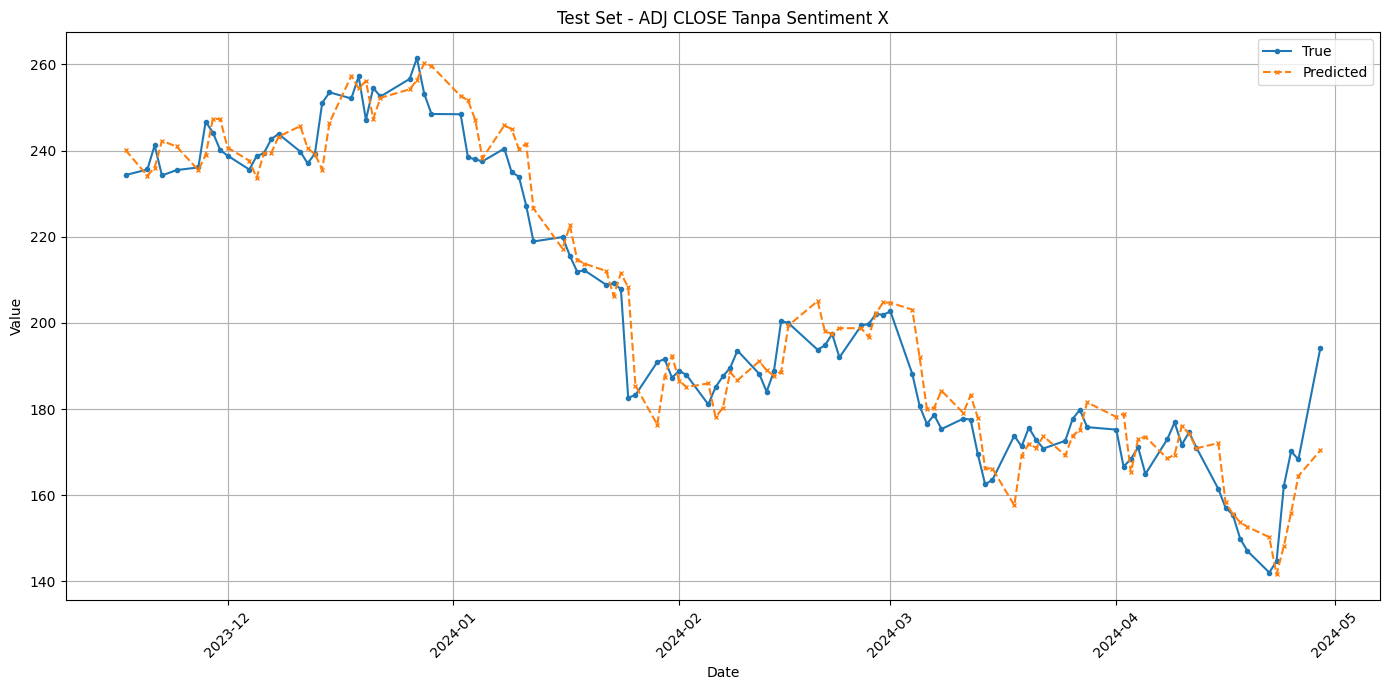

In [136]:
plot_prediction(
    y_true=y_train_true_inv,
    y_pred=y_train_pred_inv,
    dates=dates_train_full,
    feature_idx=0,
    set_name="Train",
    feature_name="OPEN"
)

plot_prediction(
    y_true=y_test_true_inv,
    y_pred=y_test_pred_inv,
    dates=dates_test,
    feature_idx=0,
    set_name="Test",
    feature_name="OPEN"
)

plot_prediction(
    y_true=y_train_true_inv,
    y_pred=y_train_pred_inv,
    dates=dates_train_full,
    feature_idx=1,
    set_name="Train",
    feature_name="ADJ CLOSE"
)

plot_prediction(
    y_true=y_test_true_inv,
    y_pred=y_test_pred_inv,
    dates=dates_test,
    feature_idx=1,
    set_name="Test",
    feature_name="ADJ CLOSE"
)

In [137]:
open_train_true = y_train_true_inv[:, 0, 0]
open_train_pred = y_train_pred_inv[:, 0, 0]
close_train_true = y_train_true_inv[:, 0, 1]
close_train_pred = y_train_pred_inv[:, 0, 1]

open_test_true = y_test_true_inv[:, 0, 0]
open_test_pred = y_test_pred_inv[:, 0, 0]
close_test_true = y_test_true_inv[:, 0, 1]
close_test_pred = y_test_pred_inv[:, 0, 1]

df_train_results = pd.DataFrame({
    'date': dates_train_full.reset_index(drop=True),
    'open_actual': open_train_true,
    'open_pred': open_train_pred,
    'close_actual': close_train_true,
    'close_pred': close_train_pred
})

df_test_results = pd.DataFrame({
    'date': dates_test.reset_index(drop=True),
    'open_actual': open_test_true,
    'open_pred': open_test_pred,
    'close_actual': close_test_true,
    'close_pred': close_test_pred
})

In [138]:
df_train_results.to_csv('train_predicted.csv',index=False)
df_train_results

,date,open_actual,open_pred,close_actual,close_pred
0,2022-02-14,287.190002,286.602844,291.920013,283.594513
1,2022-02-15,300.000000,292.599365,307.476654,289.726257
2,2022-02-16,304.683319,304.122223,307.796661,301.339722
3,2022-02-17,304.420013,310.216583,292.116669,307.680115
4,2022-02-18,295.333344,296.943726,285.660004,294.200043
...,...,...,...,...,...
438,2023-11-10,210.029999,215.343719,214.649994,214.434402
439,2023-11-13,215.600006,212.239594,223.710007,211.309067
440,2023-11-14,235.029999,226.577057,237.410004,225.965210
441,2023-11-15,239.289993,240.346024,242.839996,239.874115


In [139]:
df_test_results.to_csv('test_predicted.csv',index=False)
df_test_results

,date,open_actual,open_pred,close_actual,close_pred
0,2023-11-17,232.000000,240.735626,234.300003,240.097549
1,2023-11-20,234.039993,235.012451,235.600006,234.162796
2,2023-11-21,235.039993,236.950226,241.199997,236.047821
3,2023-11-22,242.039993,243.061218,234.210007,242.231171
4,2023-11-24,233.750000,241.789291,235.449997,240.937439
...,...,...,...,...,...
106,2024-04-23,143.330002,140.628128,144.679993,141.625931
107,2024-04-24,162.839996,146.840439,162.130005,148.190903
108,2024-04-25,158.960007,155.389694,170.179993,155.963120
109,2024-04-26,168.850006,164.471069,168.289993,164.439697


## Rolling Forecast

In [140]:
def rolling_forecast(model, initial_input, n_future_steps, target_feature_indices, scaler=None):
    rolling_input = initial_input.copy()
    predictions = []

    for _ in range(n_future_steps):
        pred = model.predict(rolling_input, verbose=0)
        pred_step = pred[:, 0, :]

        predictions.append(pred_step.flatten())

        new_input = rolling_input[:, 1:, :].copy()

        new_step = rolling_input[0, -1, :].copy()
        
        for idx, pred_val in zip(target_feature_indices, pred_step.flatten()):
            new_step[idx] = pred_val

        new_step = new_step.reshape(1, 1, -1)  # (1, 1, n_features)
        rolling_input = np.concatenate([new_input, new_step], axis=1)

    predictions = np.array(predictions)

    if scaler is not None:
        predictions = scaler.inverse_transform(predictions)

    return predictions

In [141]:
last_input = df_for_training_scaled[-n_past:].reshape(1, n_past, -1)
n_future_steps = 20
future_predictions = rolling_forecast(
    model=model,
    initial_input=last_input,
    n_future_steps=n_future_steps,
    target_feature_indices=[0, 5],
    scaler=scaler_for_inference 
)

print(f"Future predictions shape: {future_predictions.shape}")

Future predictions shape: (20, 2)


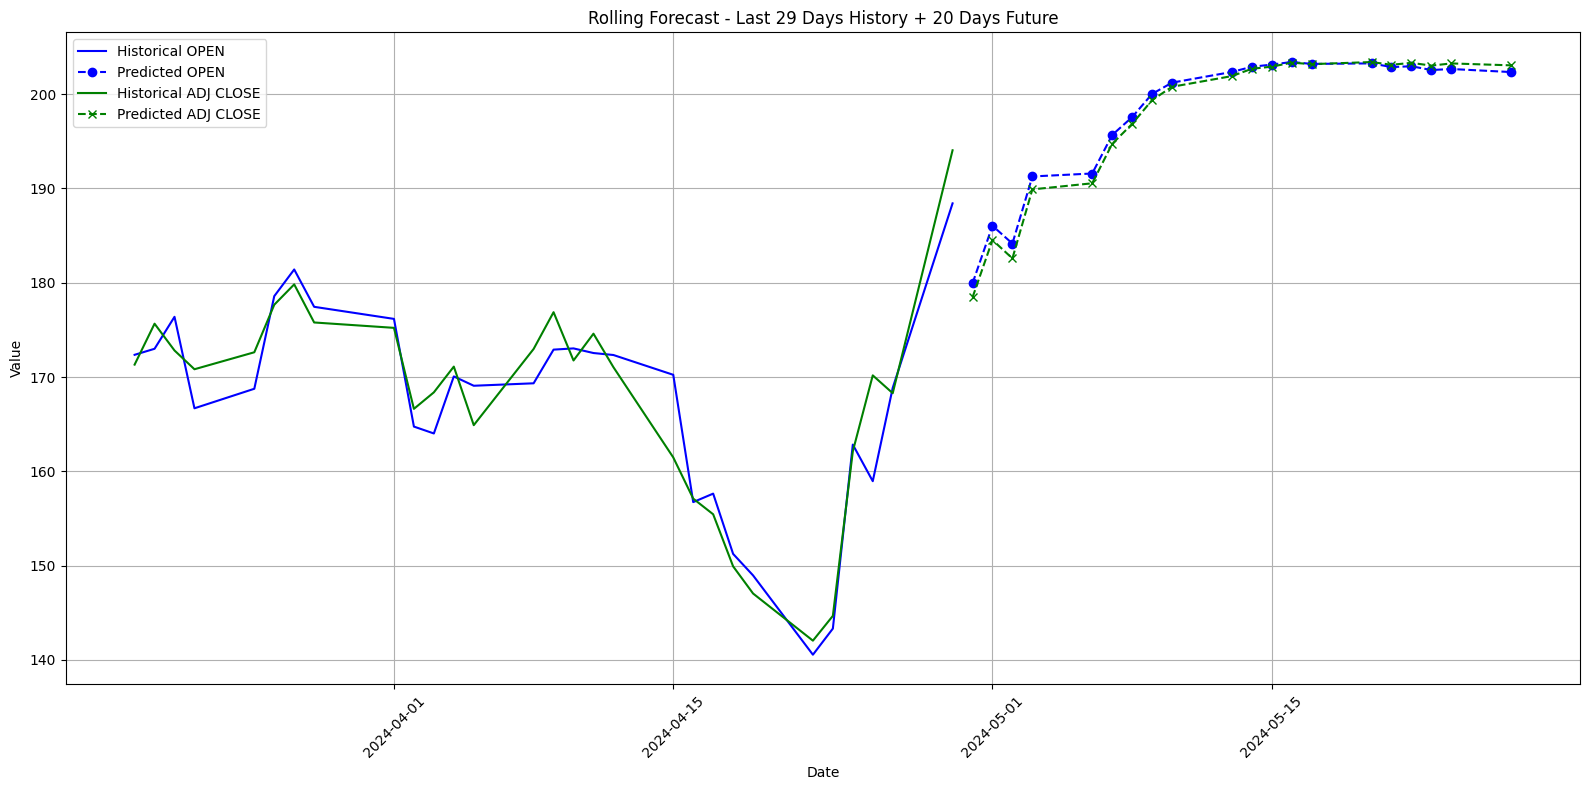

In [144]:
last_date = train_dates.iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_steps, freq='B')

n_past = 29

historical_open = df_for_training['Open'].iloc[-n_past:]
historical_adjclose = df_for_training['Adj Close'].iloc[-n_past:]
historical_dates = historical_open.index  # tanggal histori 30 hari terakhir

plt.figure(figsize=(16, 8))
plt.plot(historical_dates, historical_open.values, label='Historical OPEN', color='blue')
plt.plot(future_dates, future_predictions[:, 0], label='Predicted OPEN', color='blue', linestyle='--', marker='o')
plt.plot(historical_dates, historical_adjclose.values, label='Historical ADJ CLOSE', color='green')
plt.plot(future_dates, future_predictions[:, 1], label='Predicted ADJ CLOSE', color='green', linestyle='--', marker='x')
plt.title('Rolling Forecast - Last 29 Days History + 20 Days Future')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [143]:
df_future = pd.DataFrame(future_predictions, columns=['Predicted_Open', 'Predicted_Adj_Close'])
df_future['Date'] = future_dates.values
df_future = df_future[['Date', 'Predicted_Open', 'Predicted_Adj_Close']]
df_future.to_excel('future_predictions.xlsx',index=False)